In [15]:
%load_ext autoreload
%autoreload 2

from datasets import load_dataset
from boolrank import *

# dk what this loads
# dataset = load_dataset("data", split="train")
file = "training"
dataset = load_dataset("json", data_files=f"data/{file}.jsonl", split="train")
bool_key = "q"
text_key = "d"

data = dataset.train_test_split(test_size=0.1, seed=42)
print(data)

model = DualSiglip2Model()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
DatasetDict({
    train: Dataset({
        features: ['q', 'd'],
        num_rows: 3782
    })
    test: Dataset({
        features: ['q', 'd'],
        num_rows: 421
    })
})


You are using a model of type siglip_text_model to instantiate a model of type siglip2_text_model. This is not supported for all configurations of models and can yield errors.


In [17]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./siglip2/2",
    per_device_train_batch_size=2,
    num_train_epochs=6,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=200,
    save_steps=200,
    save_total_limit=2,
    remove_unused_columns=False,
    # max_steps=1000,
    bf16=True,
    optim="adamw_bnb_8bit",
    # torch_compile=True,
    # torch_compile_backend="inductor"
)

def collate_fn(batch):
    d = {
        "in_bool": [ex["q"] for ex in batch],
        "in_text": [ex["d"] for ex in batch],
    }
    return d

trainer = Trainer(
    model,
    training_args,
    train_dataset=data["train"],
    eval_dataset=data["test"],
    data_collator=collate_fn,
)

trainer.train(resume_from_checkpoint=False)

Step,Training Loss
200,1.154500
400,1.209200
600,1.153300
800,1.180900
1000,1.130700
1200,1.119500
1400,1.165000
1600,1.162900
1800,1.190800
2000,1.156200


TrainOutput(global_step=11346, training_loss=1.1124317727979058, metrics={'train_runtime': 1469.1129, 'train_samples_per_second': 15.446, 'train_steps_per_second': 7.723, 'total_flos': 0.0, 'train_loss': 1.1124317727979058, 'epoch': 6.0})

     Top-K | Top-K(perc) |   Recall@K
         1 |       0.00 |       0.02
         2 |       0.00 |       0.05
         4 |       0.01 |       0.07
         8 |       0.02 |       0.14
        16 |       0.04 |       0.28
        32 |       0.08 |       0.48
        64 |       0.15 |       0.71
       128 |       0.30 |       0.89
       256 |       0.61 |       0.98


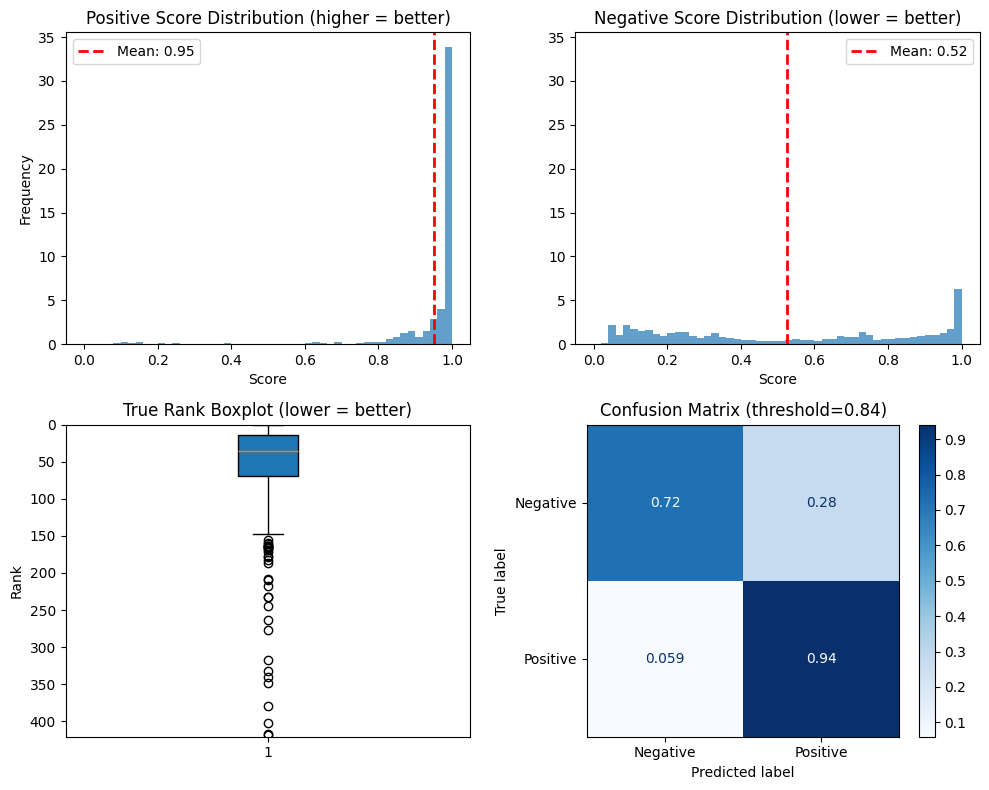

     Top-K | Top-K(perc) |   Recall@K
         1 |       0.02 |       0.04
         2 |       0.04 |       0.08
         4 |       0.08 |       0.12
         8 |       0.16 |       0.26
        16 |       0.32 |       0.46
        32 |       0.64 |       0.80


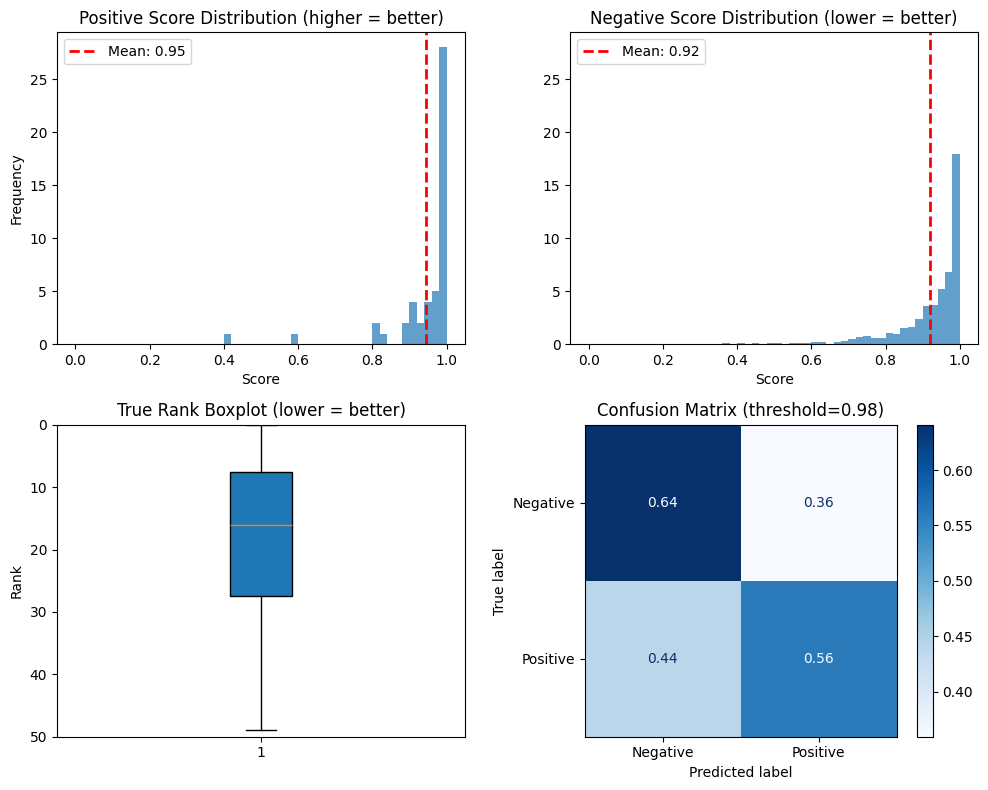

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------




In [43]:
from evaluation import ModelEvaluator

# paths = [r"./siglip2/old/b2-bf-8b/e4", r"./siglip2/old/b3-bf-8b"]
paths = [None]
amt = 2000
bench_data = load_dataset("json", data_files="data/bench_data.jsonl", split="train")
for path in paths:
    if path is not None:
        model.load(path + "/model.safetensors")
        print(path)
    eval = ModelEvaluator(model)
    eval.evaluate(data["test"][bool_key][:amt], data["test"][text_key][:amt], plot=True)
    eval.evaluate(bench_data["query"][:amt], bench_data["title"][:amt], plot=True)
    print(("-" * 100 + "\n\n") * 2)

In [ ]:
from process_data import process_searchrefiner_logs

process_searchrefiner_logs()